In [13]:
import torch
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import r2_score
import random
import matplotlib as mpl
import os
import gc
import pandas as pd
import csv
from numpy import *

from torch.utils.tensorboard import SummaryWriter
from datetime import date
from generate_property import output_property

In [14]:
data = pd.read_excel('./All_Information.xlsx')
data = data[['Sequence', 'GRAVY']]
data = data.drop(data[data['GRAVY'] == 'Not Applicable'].index)
data = np.array(data)
print('Raw data shape', data.shape)
# plt.hist(data[:,1], bins=10)
# plt.show()

Raw data shape (4011, 2)


In [15]:
## finding the largest protein
def find_max_len(data):
    max_len = 0
    for i in range(data.shape[0]):
        str_len = list(data[i,0])
        if max_len < len(str_len):
            max_len = len(str_len)
            # print(max_len)
    print('Max len is', max_len)
    return max_len

max_len = find_max_len(data)

Max len is 97


In [16]:
# # different amino acids
amino_acid = ['A', 'V', 'F', 'I', 'L','D','E','K','S','T','Y','C','N','Q', 'P','M', 'R', 'H', 'W', 'G'] # O is the uncommon amino acid, so total length is 21
# amino_acid = ['A', 'V', 'F', 'I', 'L','D','E','K','S','T','Y','C','N','Q', 'P','M', 'R', 'H', 'W', 'G','X'] # O is the uncommon amino acid, so total length is 21
print('Number of unique amino acids are', np.shape(np.unique(amino_acid))[0])
np.save('../model/categorical_variables', amino_acid)

def onehotseq(sequence):
  aa_seq = ''
  seq_len = len(sequence)
  seq_en = np.zeros(( seq_len, np.shape(amino_acid)[0]))
  act_len = 0
  for i in range(seq_len):
    if sequence[i] in amino_acid:
      pos = amino_acid.index(sequence[i])
      seq_en[act_len,pos] = 1
      act_len += 1  
      aa_seq += sequence[i]    
    elif (sequence[i] not in amino_acid) and (sequence[i] != " ") and (sequence[i] != '\ufeff'):
      pos = amino_acid.index('X')
      seq_en[act_len,pos] = 1
      act_len += 1 
      aa_seq += sequence[i]
  return seq_en[0:act_len, :], aa_seq

Number of unique amino acids are 20


In [17]:
# max_len = find_max_len(data)
ohe = np.zeros((data.shape[0], max_len, len(amino_acid)))  ## batch size*sequenc_len*21
seq_string = np.zeros((data.shape[0],), dtype=object) ## it will store the string of amino acids
seq_lengths = np.zeros((data.shape[0],))
tm = np.zeros((data.shape[0], 1))

for i in range(ohe.shape[0]):
    seq_en, aa_seq = onehotseq(list(data[i,0]))
    seq_string[i,] = aa_seq
    ohe[i,0:seq_en.shape[0],:] =  seq_en
    seq_lengths[i,] = seq_en.shape[0]
    tm[i,0] = data[i,1]

# print(seq_string)
# np.save('./pure_b_factor_model/collagen_all_ohe', ohe)
# np.save('./pure_b_factor_model/collagen_all_seq_lengths', seq_lengths)
# np.save('./pure_b_factor_model/collagen_all_tm', tm)
output_y = tm
seq_length = seq_lengths

toy_prop=  output_property(ohe, seq_length)

output_y = toy_prop

idx_20 = (seq_length>20)
seq_length = seq_length[idx_20]
ohe = ohe[idx_20]
output_y = output_y[idx_20]

In [18]:
all_ex = np.arange(ohe.shape[0])
X, x_test, _, _ = train_test_split( all_ex, all_ex, test_size=0.127,random_state=50) ## [10,50,70]
x_train, x_valid, _, _ = train_test_split( X, X, test_size=0.145,random_state=50)

print('Train',x_train.shape)
print('Test' ,x_test.shape)
print('Valid',x_valid.shape)

print(ohe[x_train].shape, seq_length[x_train].shape, output_y[x_train].shape)

Train (879,)
Test (150,)
Valid (150,)
(879, 97, 20) (879,) (879,)


In [19]:
np.save('./x_train', ohe[x_train])
np.save('./len_train', seq_length[x_train])
np.save('./y_train', output_y[x_train])

np.save('./x_valid', ohe[x_valid])
np.save('./len_valid', seq_length[x_valid])
np.save('./y_valid', output_y[x_valid])

np.save('./x_test', ohe[x_test])
np.save('./len_test', seq_length[x_test])
np.save('./y_test', output_y[x_test])

    
# np.save('./store_data/x_train'+str(trial), ohe[x_train])
# np.save('./store_data/len_train'+str(trial), seq_length[x_train])
# np.save('./store_data/y_train'+str(trial), output_y[x_train])

# np.save('./store_data/x_valid'+str(trial), ohe[x_valid])
# np.save('./store_data/len_valid'+str(trial), seq_length[x_valid])
# np.save('./store_data/y_valid'+str(trial), output_y[x_valid])

# np.save('./store_data/x_test'+str(trial), ohe[x_test])
# np.save('./store_data/len_test'+str(trial), seq_length[x_test])
# np.save('./store_data/y_test'+str(trial), output_y[x_test])

(array([ 59., 259., 190., 204., 183., 143.,  92.,  28.,  19.,   2.]),
 array([  0.        ,  22.28571429,  44.57142857,  66.85714286,
         89.14285714, 111.42857143, 133.71428571, 156.        ,
        178.28571429, 200.57142857, 222.85714286]),
 <BarContainer object of 10 artists>)

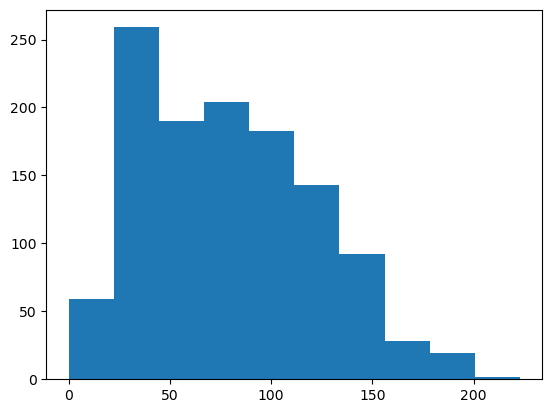

In [20]:
plt.hist(output_y)